In [207]:
import os
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchtext

from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator
import torch.nn.functional as F


from nltk.metrics import distance
from nltk.translate.bleu_score import sentence_bleu

# Data

In [57]:
data = pd.read_csv('csv/test.csv')
data

,Unnamed: 0,word,lemma,pos_tag,freq,word_length,lemma_length,ratio,lemma_length_category,word_length_category,ratio_category,reported_speech,freq_category
0,143445,საჩემოა,საჩემო,A,10,7,6,1.166667,low,low,greater,False,medium
1,805277,საჭმელ-სასმელით,საჭმელსასმელი,N,15,15,13,1.153846,high,high,greater,False,medium
2,902975,დავნაძლევდით,დანაძლევება,V,4,12,11,1.090909,high,high,greater,False,medium
3,55733,ჯორჯი,ჯორჯ,N,330,5,4,1.250000,low,low,greater,False,high
4,228515,გამეშვი,გაშვება,V,13,7,7,1.000000,low,low,equal,False,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
410093,671912,ყმაშია,ყმა,N,2,6,3,2.000000,low,low,greater,False,low
410094,339503,სათხარი,სათხარი,A,1,7,7,1.000000,low,low,equal,False,low
410095,1060380,ასანთმასალებისკენ,ასანთმასალა,N,1,17,11,1.545455,high,high,greater,False,low
410096,1315693,პაულუმაც,პაულუ,N,4,8,5,1.600000,low,low,greater,False,medium


## Preparation

In [204]:
MAX_LENGTH = 37
AVG_LENGTH = data.lemma.str.len().mean()
AVG_LENGTH

8.114172709937625

In [59]:
def get_tokens(t):
    yield from list(t)

UNK_TOKEN = '<unk>'
EOW_TOKEN = '<end>'
PAD_TOKEN = '<pad>'
SOW_TOKEN = '<start>'

vocab = build_vocab_from_iterator(iterator=get_tokens(itertools.chain(data['word'], data['lemma'])),
                                  specials=[EOW_TOKEN, UNK_TOKEN, PAD_TOKEN, SOW_TOKEN],
                                  special_first=False
                                  )
vocab.set_default_index(vocab[UNK_TOKEN])

def word_to_seq(word: str):
    return torch.tensor(vocab(list(word)) + [vocab[EOW_TOKEN]])

In [60]:
class LemmaDataSet(Dataset):
    def __init__(self, data_frame: pd.DataFrame):
        self.data = data_frame

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> (str, str):
        row = self.data.iloc[idx]
        return row['word'], row['lemma']


In [61]:
def coallate_words(batch):
    word_list, lemma_list = [torch.zeros(MAX_LENGTH, dtype=torch.int64)], [torch.zeros(MAX_LENGTH, dtype=torch.int64)]
    for word, lemma in batch:
        word_list.append(word_to_seq(word))
        lemma_list.append(word_to_seq(lemma))


    return pad_sequence(word_list, batch_first=True, padding_value=vocab[PAD_TOKEN])[1:], pad_sequence(lemma_list, batch_first=True, padding_value=vocab[PAD_TOKEN])[1:]

# Model

In [238]:
MODEL_NAME = 'base_model_v0.pt'
MODEL_WEIGHTS = 'base_model_v2.pt'

In [239]:
model = torch.jit.load(os.path.join('models', MODEL_NAME))
model.load_state_dict(torch.load(os.path.join('weights', MODEL_WEIGHTS)))
model.eval()
print(f'Number of Parameters: {sum(p.numel() for p in model.parameters())}')

Number of Parameters: 57447


# Evaluation

In [240]:
# Metrics
def edit_distances(target: torch.Tensor, pred: torch.Tensor):
    return [distance.edit_distance(t, p) for t, p in zip(target.tolist(), pred.tolist())]

def accurecy(target: torch.Tensor, pred: torch.Tensor):
    return [1 if t == p else 0 for t, p in zip(target.tolist(), pred.tolist())]

In [241]:
def evaluate(model, loader):
    acc = 0
    total = 0
    edit_distance = 0
    for i, (x, y) in enumerate(loader):
        y_pred = model(y).argmax(dim=2)
        acc += sum(accurecy(y, y_pred))
        total += x.size()[0]
        edit_distance += sum(edit_distances(y, y_pred))
    print(f'Avg Accurecy: {acc / total}, Avg Edit Distance {edit_distance / total}')
    return acc / total, edit_distance / total
    
# MAX_LENGTH * total - bad 0 - good 

In [242]:
def evaluate_category(cat_data):
    points = []
    for dtype, df in cat_data.items():
        print(f'Type: {dtype}')
        loader = DataLoader(LemmaDataSet(df), batch_size=128, collate_fn=coallate_words)
        acc, edit_distance = evaluate(model, loader)
        points.append({'type': dtype, 'accuracy': acc, 'edit_distance': edit_distance, 'avg_length': df.lemma.str.len().mean()})

    fig, axs = plt.subplots(nrows=5, figsize=(8, 17))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.3)
    df = pd.DataFrame(points)

    # Average Edit Distance - Avg. Number of character differences between target and predicted words
    # Normalized Edit Distance - Average Edit Distance / Avg.Length of a target word by category
    df['norm_distance'] = df['edit_distance'] / df['avg_length'] 

    # Average Inverse Distance is computed in a following manner:
    # 1 - Normalized Edit Distance

    df['inv_distance'] = 1 - df['norm_distance']  

    axs[2].set_title('Avg. Edit Distance')
    sns.barplot(df.sort_values(by='edit_distance', ascending=True), x='type', y='edit_distance', ax=axs[2])
    axs[3].set_title('Avg. Normalized Edit Distance')
    sns.barplot(df.sort_values(by='norm_distance', ascending=True), x='type', y='norm_distance', ax=axs[3])
    axs[4].set_title('Avg. Inverse Edit Distance')
    sns.barplot(df.sort_values(by='inv_distance', ascending=False), x='type', y='inv_distance', ax=axs[4])

    axs[1].set_title('Avg. Accuracy')
    sns.barplot(df.sort_values(by='accuracy', ascending=False), x='type', y='accuracy', ax=axs[1])

    df_melted = df.melt(id_vars='type', var_name='metric', value_name='value', value_vars=['accuracy', 'inv_distance'])
    sns.barplot(df_melted, x='type', y='value', hue='metric', ax=axs[0])


## Edit Distance

In [243]:
data['edit_distance'] = data.apply(lambda x: distance.edit_distance(x.word, x.lemma), axis=1)

<Axes: xlabel='edit_distance', ylabel='count'>

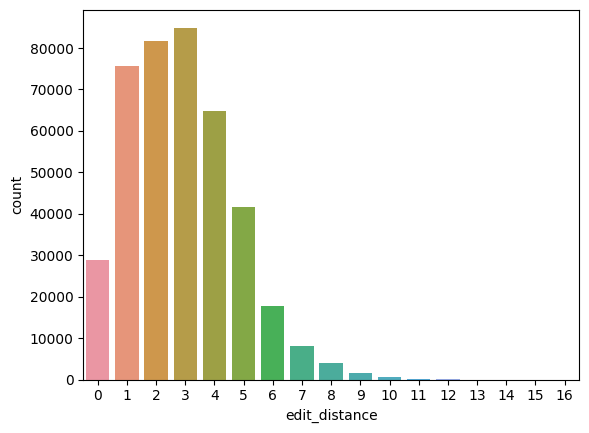

In [244]:
sns.countplot(data, x ='edit_distance')

In [245]:
by_edit_distance = dict(list(data.groupby('edit_distance')))

Type: 0
Avg Accurecy: 0.7098842448187427, Avg Edit Distance 0.8678519442711582
Type: 1
Avg Accurecy: 0.7598236559707501, Avg Edit Distance 0.694447010995103
Type: 2
Avg Accurecy: 0.7551312299059937, Avg Edit Distance 0.7757172719826901
Type: 3
Avg Accurecy: 0.7645223574842827, Avg Edit Distance 0.8332195248298759
Type: 4
Avg Accurecy: 0.764419660786555, Avg Edit Distance 0.8503043035002626
Type: 5
Avg Accurecy: 0.7723095380923816, Avg Edit Distance 0.8435512897420516
Type: 6
Avg Accurecy: 0.7400258122439818, Avg Edit Distance 0.9881600359126873
Type: 7
Avg Accurecy: 0.7375233354075917, Avg Edit Distance 1.038954573739888
Type: 8
Avg Accurecy: 0.7361563517915309, Avg Edit Distance 1.0215484840892006
Type: 9
Avg Accurecy: 0.7200736648250461, Avg Edit Distance 1.2166973603437692
Type: 10
Avg Accurecy: 0.7244367417677643, Avg Edit Distance 1.218370883882149
Type: 11
Avg Accurecy: 0.65, Avg Edit Distance 1.4666666666666666
Type: 12
Avg Accurecy: 0.5483870967741935, Avg Edit Distance 2.11290

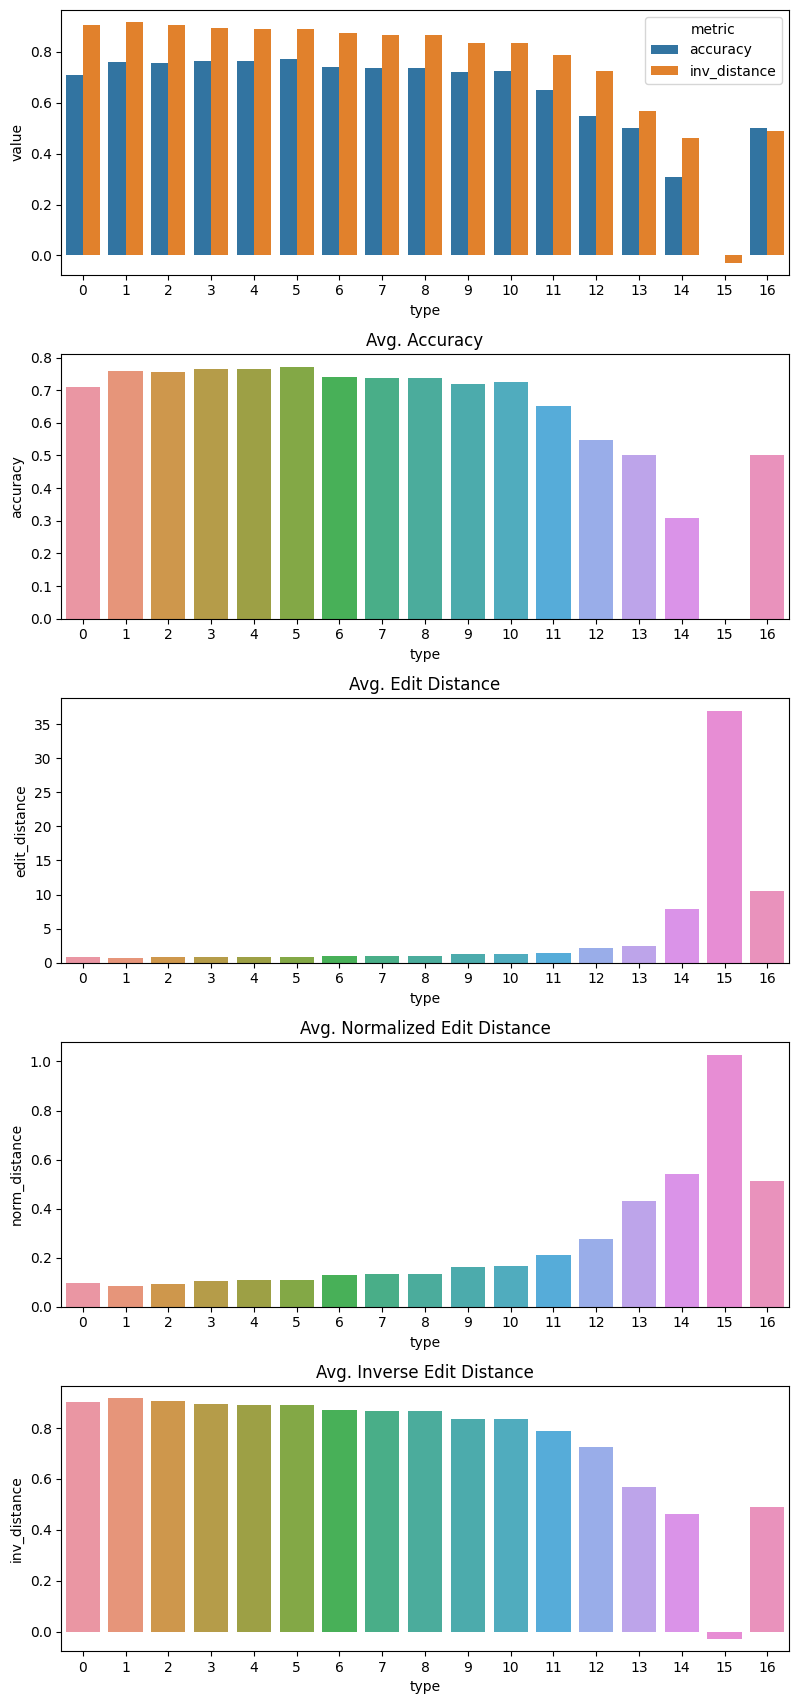

In [246]:
evaluate_category(by_edit_distance)

## POS Tags

<Axes: xlabel='pos_tag', ylabel='count'>

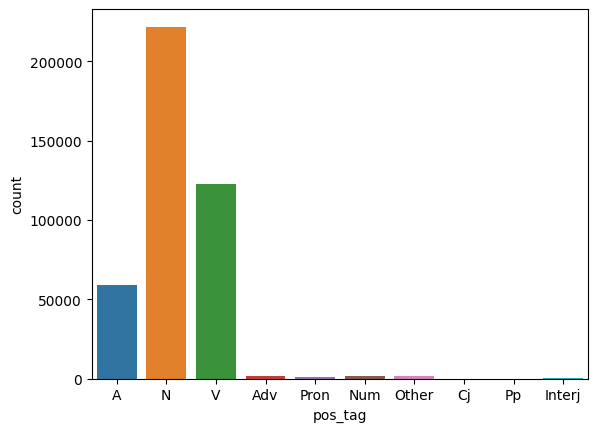

In [247]:
sns.countplot(data, x ='pos_tag')

In [248]:
by_pos_tag = dict(list(data.groupby('pos_tag')))

Type: A
Avg Accurecy: 0.805976753288746, Avg Edit Distance 0.6081754905464509
Type: Adv
Avg Accurecy: 0.13860369609856263, Avg Edit Distance 2.6006160164271046
Type: Cj
Avg Accurecy: 0.367816091954023, Avg Edit Distance 1.6666666666666667
Type: Interj
Avg Accurecy: 0.32196969696969696, Avg Edit Distance 1.7196969696969697
Type: N
Avg Accurecy: 0.747409414002461, Avg Edit Distance 0.6992080627059285
Type: Num
Avg Accurecy: 0.5429155313351499, Avg Edit Distance 1.7438692098092643
Type: Other
Avg Accurecy: 0.7265209686946249, Avg Edit Distance 0.7643236857649144
Type: Pp
Avg Accurecy: 0.203125, Avg Edit Distance 2.03125
Type: Pron
Avg Accurecy: 0.42257001647446457, Avg Edit Distance 1.5782537067545306
Type: V
Avg Accurecy: 0.7668122341899004, Avg Edit Distance 1.0833890074793462


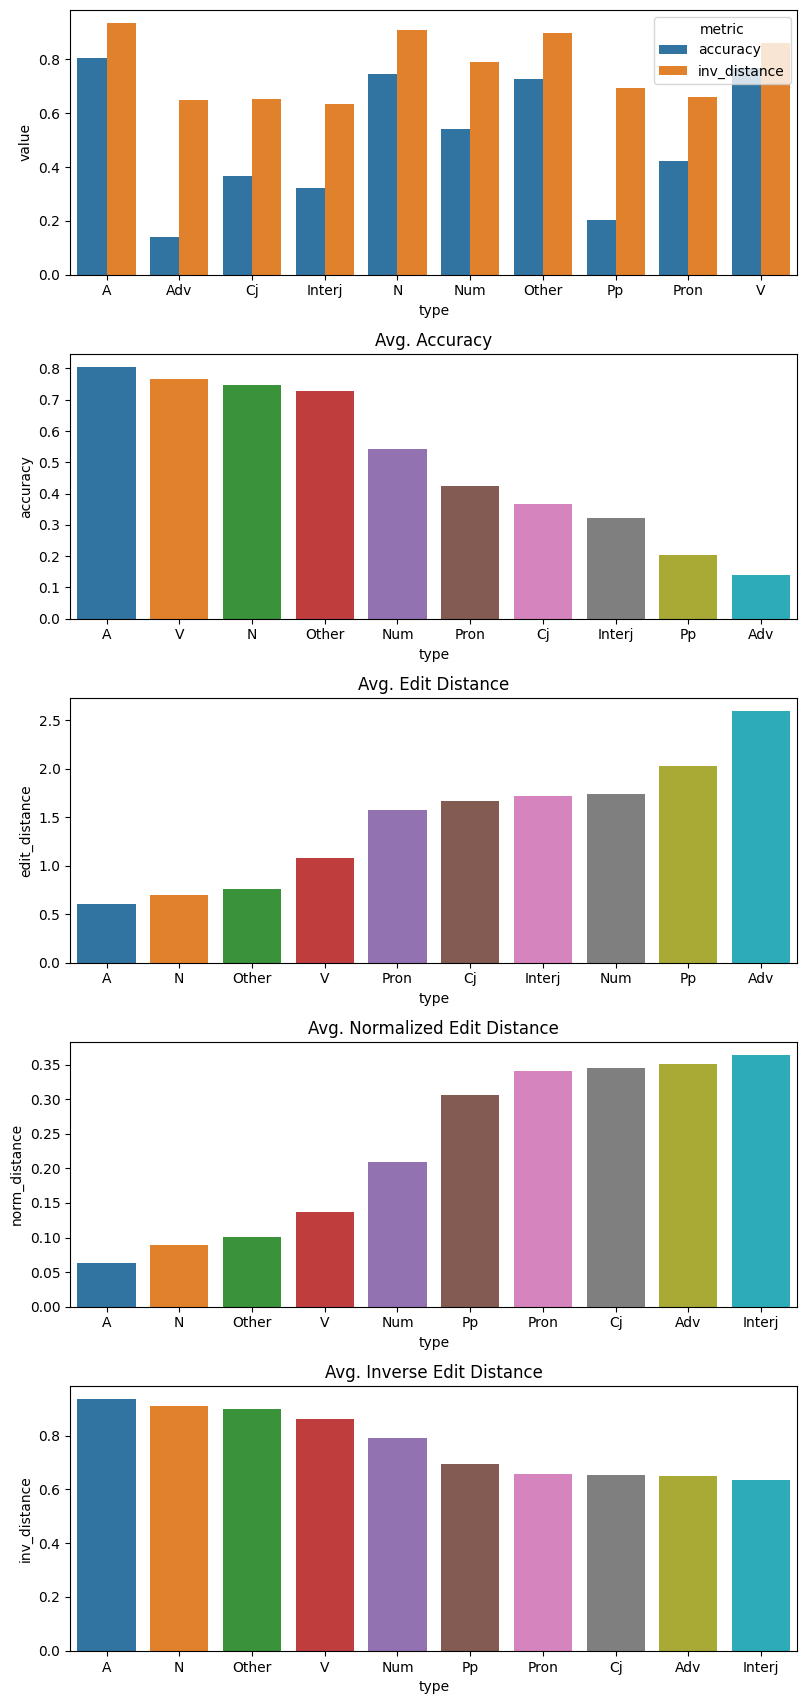

In [249]:
evaluate_category(by_pos_tag)

## word_length

<Axes: xlabel='word_length_category', ylabel='count'>

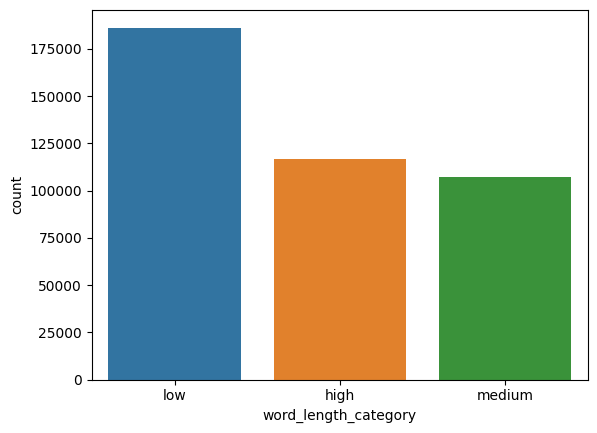

In [250]:
sns.countplot(data, x ='word_length_category')

In [251]:
by_word_length = dict(list(data.groupby('word_length_category')))

Type: high
Avg Accurecy: 0.7369938240979933, Avg Edit Distance 0.9270439498400425
Type: low
Avg Accurecy: 0.7517221014200961, Avg Edit Distance 0.8150009395720921
Type: medium
Avg Accurecy: 0.7861357621777308, Avg Edit Distance 0.7034702675407015


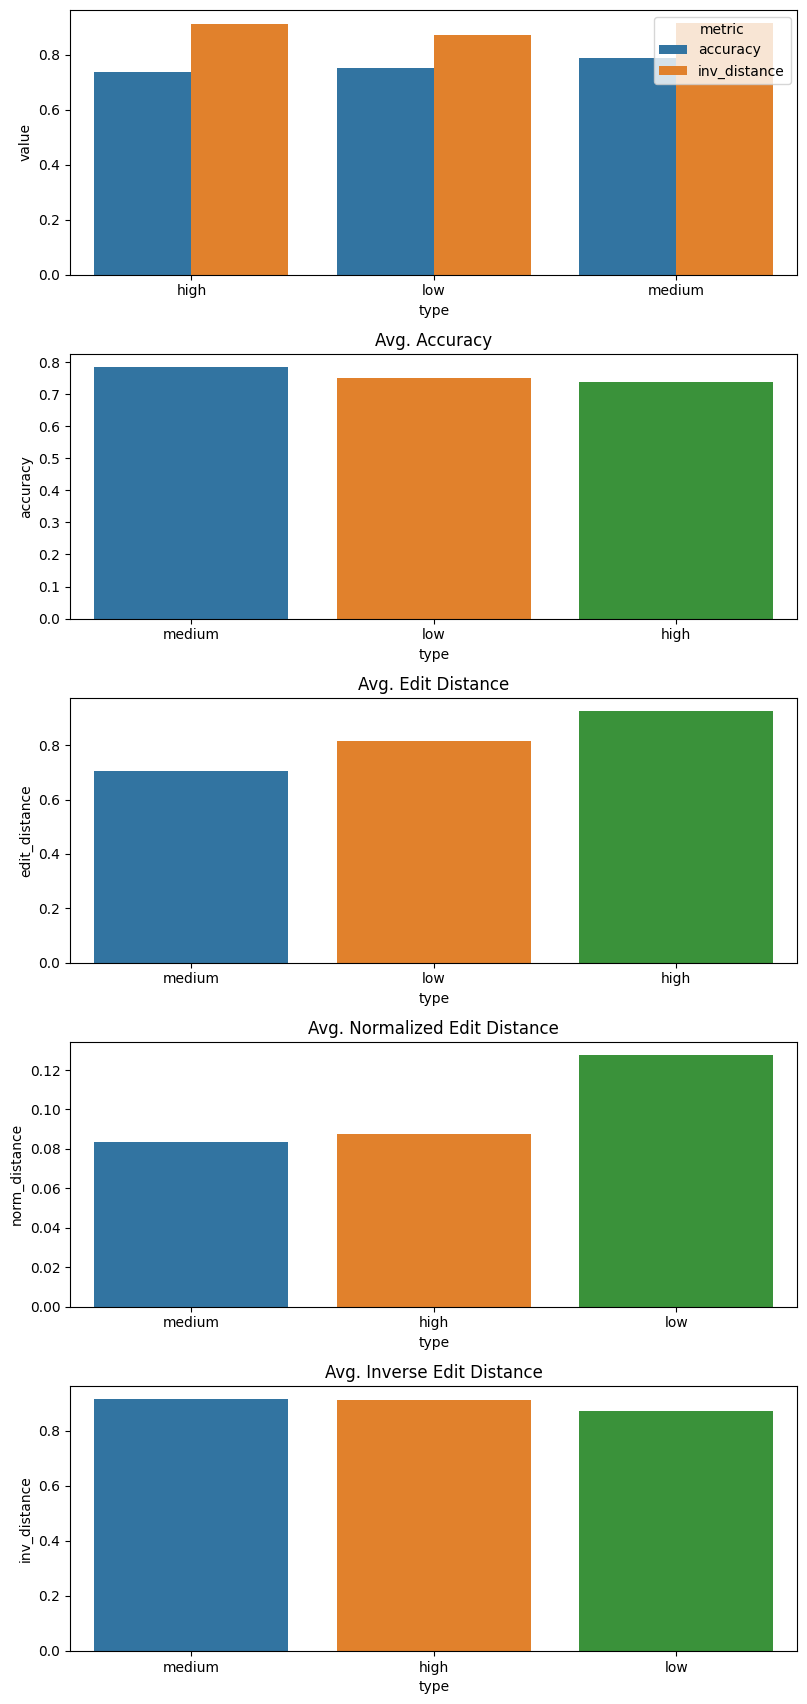

In [252]:
evaluate_category(by_word_length)

## lemma length

<Axes: xlabel='lemma_length_category', ylabel='count'>

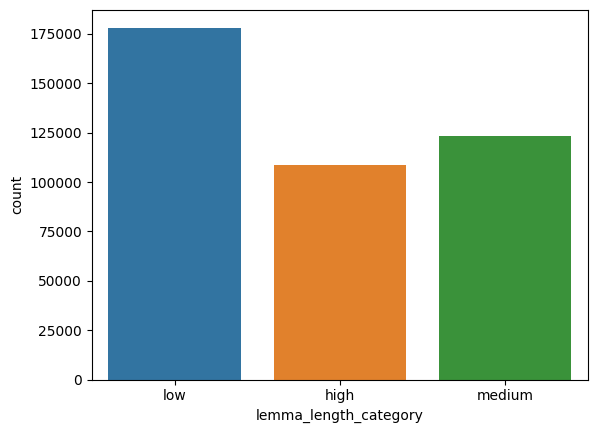

In [253]:
sns.countplot(data, x ='lemma_length_category')

In [254]:
by_lemma_length = dict(list(data.groupby('lemma_length_category')))

In [ ]:
evaluate_category(by_lemma_length)

Type: high
Avg Accurecy: 0.7386281987508981, Avg Edit Distance 0.9424178780007001
Type: low
Avg Accurecy: 0.7305926333396948, Avg Edit Distance 0.8725260168169112
Type: medium


## Word Length / Lemma Length Ratio

In [ ]:
sns.countplot(data, x ='ratio_category')

In [ ]:
by_ratio = dict(list(data.groupby('ratio_category')))

In [ ]:
evaluate_category(by_ratio)

## Frequencies

In [ ]:
sns.countplot(data, x ='freq_category')

In [ ]:
by_freq = dict(list(data.groupby('freq_category')))

In [ ]:
evaluate_category(by_freq)

## Reported Speech

In [ ]:
sns.countplot(data, x ='reported_speech')

In [ ]:
by_reported_speech = dict(list(data.groupby('reported_speech')))

In [ ]:
evaluate_category(by_reported_speech)